## Background
train.csv: /kaggle/input/playground-series-s5e12/train.csv
test.csv: /kaggle/input/playground-series-s5e12/test.csv
orig dataset: /kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv

The LB only has 20% of the test data, while only the PB has the complete 100% test data.
The competition dataset is synthesized based on the orig dataset. However, because the diabetes prediction task is too simple, to widen the gap between competitors, the organizers intentionally removed strong features from the original data (e.g. HbA1c). Just as analyzed in this post:
"Principal Component Analysis identified five key health clusters: age-related metabolic indicators (AGE, HbA1c, BMI), kidney function markers (Cr, Urea), cardiovascular lipid profiles (Cholesterol, LDL), lipid transport (VLDL), and protective cardiovascular indicators (HDL)." Among these indicators founded above, ours Playground competition has Age, BMI, Cholesterol (total), LDL (low density) and HDL (high density). Unfortunately, data doesn't have HbA1c (glycated hemoglobin), used to measure an individual's glucose control levels, which is the paramount factor in predicting diabetes mellitus.

`https://www.kaggle.com/code/daylighth/ps-s5e12-hypothesis`

### Exp0
In fact, we can examine the covariate shift relationship between datasets via Adversarial Validation analysis.
Here is the AV analysis code for the train and test sets; subsequent analysis code is omitted as we only need to focus on the results.


#### train-test

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def av(X1, X2):
    X = pd.concat([X1, X2])
    X = X.astype({c: 'category' for c in X.columns if X[c].dtype=='object'})
    y = np.array([1]*len(X1)+[0]*len(X2))
    return cross_val_score(
        XGBClassifier(
            enable_categorical=True,
            n_jobs=4, random_state=0
        ), X, y, n_jobs=1,
        cv=StratifiedKFold(5, shuffle=True, random_state=0),
        scoring='roc_auc'  
    ).mean()

train = pd.read_csv('D:\\ps-s5e12-diabetes\\data\\train.csv', index_col='id')
test = pd.read_csv('D:\\ps-s5e12-diabetes\\data\\test.csv', index_col='id')

for c in test.columns:
    auc = av(train[[c]], test[[c]])
    print(F'{c}: AUC={auc:.2f}')

age: AUC=0.51
alcohol_consumption_per_week: AUC=0.50
physical_activity_minutes_per_week: AUC=0.58
diet_score: AUC=0.51
sleep_hours_per_day: AUC=0.51
screen_time_hours_per_day: AUC=0.51
bmi: AUC=0.51
waist_to_hip_ratio: AUC=0.51
systolic_bp: AUC=0.51
diastolic_bp: AUC=0.51
heart_rate: AUC=0.51
cholesterol_total: AUC=0.53
hdl_cholesterol: AUC=0.51
ldl_cholesterol: AUC=0.53
triglycerides: AUC=0.56
gender: AUC=0.50
ethnicity: AUC=0.51
education_level: AUC=0.51
income_level: AUC=0.50
smoking_status: AUC=0.50
employment_status: AUC=0.51
family_history_diabetes: AUC=0.50
hypertension_history: AUC=0.50
cardiovascular_history: AUC=0.50


#### Conclusion

Preliminary analysis shows that there is some covariate shift between train and test, but the OOF is basically reliable. There is a gap between CV and LB, but I think this is a normal occurrence and not necessarily a signal of overfitting. Moreover, in this competition, the public LB only comprises 20% of the data.
The difference between the orig dataset and the competition dataset is relatively larger, so directly concatenating the orig data is not feasible in this competition. However, I do not think this implies that the orig dataset is useless.

1. Loading Data & Preprocessing...
2. Starting MICRO-SCAN from ID 600000 (Index 600000)...
   Using Window=20000, Step=1000
   Window Start: 600000   | AUC: 0.6172
   Window Start: 601000   | AUC: 0.6173
   Window Start: 602000   | AUC: 0.6160
   Window Start: 603000   | AUC: 0.6165
   Window Start: 604000   | AUC: 0.6175
   Window Start: 605000   | AUC: 0.6176
   Window Start: 606000   | AUC: 0.6168
   Window Start: 607000   | AUC: 0.6166
   Window Start: 608000   | AUC: 0.6166
   Window Start: 609000   | AUC: 0.6167
   Window Start: 610000   | AUC: 0.6163
   Window Start: 611000   | AUC: 0.6174
   Window Start: 612000   | AUC: 0.6160
   Window Start: 613000   | AUC: 0.6164
   Window Start: 614000   | AUC: 0.6177
   Window Start: 615000   | AUC: 0.6171
   Window Start: 616000   | AUC: 0.6175
   Window Start: 617000   | AUC: 0.6186
   Window Start: 618000   | AUC: 0.6200
   Window Start: 619000   | AUC: 0.6188
   Window Start: 620000   | AUC: 0.6177
   Window Start: 621000   | AUC: 0.6

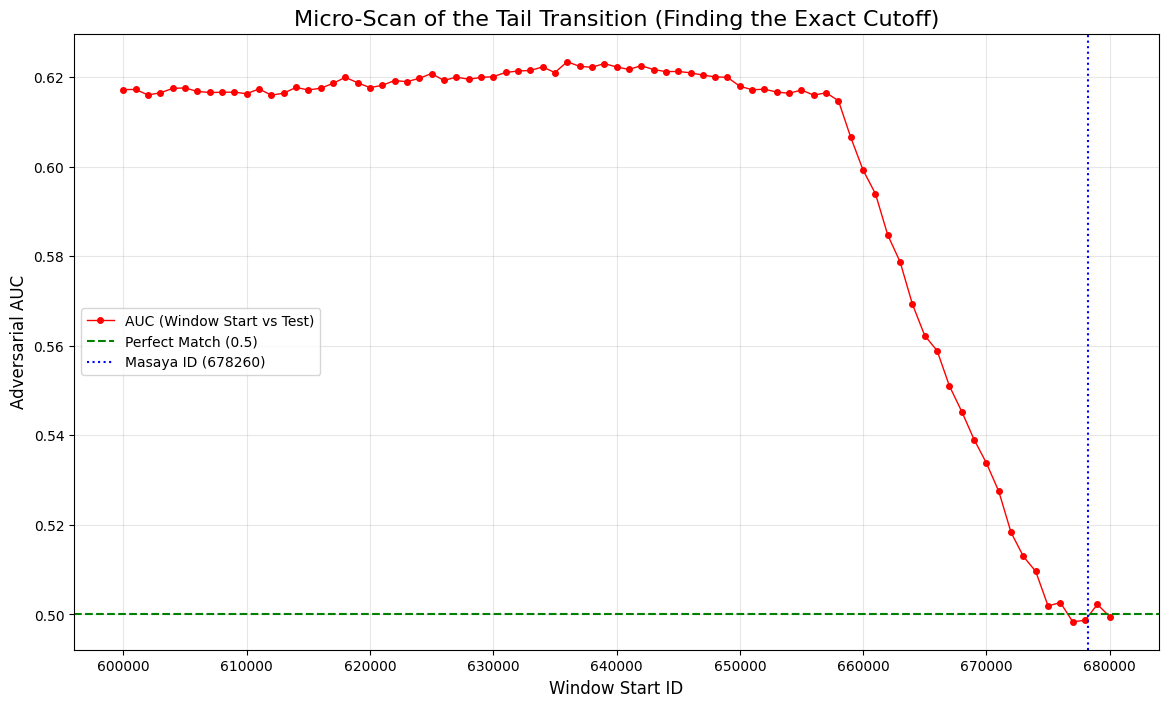


✅ First 'Clean' ID (AUC < 0.52): 672000
🏆 Best ID (Lowest AUC 0.4984): 677000


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

TRAIN_PATH = "D:\\ps-s5e12-diabetes\\data\\train.csv"
TEST_PATH = "D:\\ps-s5e12-diabetes\\data\\test.csv"
ORIG_PATH = "D:\\ps-s5e12-diabetes\\data\\diabetes_dataset.csv"

SCAN_START_ID = 600000 
WINDOW_SIZE = 20000    
STEP_SIZE = 1000       

print("1. Loading Data & Preprocessing...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
df_orig = pd.read_csv(ORIG_PATH)

features = [c for c in train.columns if c not in ['id', 'diagnosed_diabetes'] and c in test.columns]
X_train_raw = train[features].copy()
X_test_raw = test[features].copy()

X_train_raw['_is_train'] = 1
X_test_raw['_is_train'] = 0
df_all = pd.concat([X_train_raw, X_test_raw], axis=0).reset_index(drop=True)

cat_cols = df_all.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))

X_train_full = df_all[df_all['_is_train'] == 1].drop(columns=['_is_train']).reset_index(drop=True)
X_test_full = df_all[df_all['_is_train'] == 0].drop(columns=['_is_train']).reset_index(drop=True)
y_test = np.ones(len(X_test_full))
train_ids = train['id'].values

start_index = train[train['id'] >= SCAN_START_ID].index[0]

print(f"2. Starting MICRO-SCAN from ID {SCAN_START_ID} (Index {start_index})...")
print(f"   Using Window={WINDOW_SIZE}, Step={STEP_SIZE}")

results = []
centers = []

params = {
    'objective': 'binary', 'metric': 'auc', 'n_estimators': 100,
    'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42, 'verbose': -1, 'n_jobs': -1
}

for start_idx in range(start_index, len(X_train_full) - WINDOW_SIZE + 1, STEP_SIZE):
    end_idx = start_idx + WINDOW_SIZE
    
    X_subset = X_train_full.iloc[start_idx:end_idx]
    y_subset = np.zeros(len(X_subset))
    
    X_adv = pd.concat([X_subset, X_test_full], axis=0)
    y_adv = np.concatenate([y_subset, y_test])
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for t_idx, v_idx in skf.split(X_adv, y_adv):
        X_t, y_t = X_adv.iloc[t_idx], y_adv[t_idx]
        X_v, y_v = X_adv.iloc[v_idx], y_adv[v_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_t, y_t)
        preds = model.predict_proba(X_v)[:, 1]
        aucs.append(roc_auc_score(y_v, preds))
    
    avg_auc = np.mean(aucs)
    
    window_start_id = train_ids[start_idx]
    
    results.append(avg_auc)
    centers.append(window_start_id)
    
    print(f"   Window Start: {window_start_id:<8} | AUC: {avg_auc:.4f}")

plt.figure(figsize=(14, 8))
plt.plot(centers, results, 'o-', color='red', markersize=4, linewidth=1, label='AUC (Window Start vs Test)')

plt.axhline(0.5, color='green', linestyle='--', label='Perfect Match (0.5)')
plt.axvline(678260, color='blue', linestyle=':', label='Masaya ID (678260)')

plt.title("Micro-Scan of the Tail Transition (Finding the Exact Cutoff)", fontsize=16)
plt.xlabel("Window Start ID", fontsize=12)
plt.ylabel("Adversarial AUC", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

candidates = [centers[i] for i, auc in enumerate(results) if auc < 0.52]
if candidates:
    print(f"\n✅ First 'Clean' ID (AUC < 0.52): {candidates[0]}")
    min_auc = min(results)
    best_id = centers[results.index(min_auc)]
    print(f"🏆 Best ID (Lowest AUC {min_auc:.4f}): {best_id}")
else:
    print("\n⚠️ No clean point found. Check range or metric.")

It can be seen that there is indeed a pattern where the closer to the end, the closer to the test set.

Naturally, we can think of using a simple adversarial trainer to determine which samples in Head are similar to Tail, and then weight the samples in Head that are similar to Tail. To demonstrate the feasibility of this approach, we use a LightGBM trainer for training and then divide the data into 9 bins based on similarity. The larger the number, the higher the similarity; we then observe the Target mean to see if each bin is close to Tail.

In result, the representative practice in the community is to assign a 16x weight to the tail data, an 8x weight to the original data, and a 1x weight to the head data. This approach is simple, avoids the concept shift within Head, and utilizes all data effectively.

### Discussion

The adversarial validation (AV) results show a consistent signal: `train` and `test` are distinguishable, but not uniformly across all features. In single-feature AV, `physical_activity_minutes_per_week` (AUC ~ 0.58) and `triglycerides` (AUC ~ 0.56) shift more than most other variables (mostly ~0.50-0.53), indicating partial rather than global covariate shift.

The micro-scan supports the hypothesis that later training samples are closer to the test distribution. Starting around `id=600000`, window-level AV AUC is about 0.62; it then declines steadily, first dropping below 0.52 at `id=672000`, with the minimum near `id=677000` (AUC ~ 0.4984). Since AUC closer to 0.50 means harder train-vs-test discrimination, this region is a reasonable "clean tail" candidate.

A key caveat is dataset provenance: the competition `train` and `test` were synthetically generated by a deep model trained on the Diabetes Health Indicators dataset. This can constrain model behavior and leaderboard dynamics in ways that may not transfer to real production systems. In real deployments, data-generating processes, missingness, and concept drift are often more complex than in synthetic benchmarks.

About leakage risk when using `test` and the original dataset:
1. Using unlabeled `test` features for AV, distribution alignment, or transductive reweighting is not direct target leakage, but it is still test-informed modeling. This is often acceptable in competitions, but should be flagged because it inflates dependence on the specific test distribution.
2. Merging or engineering features from the original Diabetes Health Indicators dataset is not automatically leakage either, but it can introduce contamination risk if near-duplicate records, proxy identifiers, or target-correlated artifacts transfer into training.
3. Any transformation fit on `train+test` (e.g., encoders, bins, normalization) should be treated as transductive. For production-like validation, fit transformations on training folds only and apply to validation/test without refitting.
